In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from collections import Counter
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
def readin_data(data_type: str):
    """ This function reads in test or train data, which must be in folders 'testing_data' and 'training_data' in the same directory.

    Parameters
    ----------
    'data_type' : str
        This must be 'test' or 'train'.
    """
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'
    if data_type == 'test':
        inner_directory = './testing_data/'
        data_list = os.listdir('./testing_data')
    else:
        inner_directory = './training_data/'
        data_list = os.listdir('./training_data')
    data_dict = {}
    for file_name in data_list:
        data_dict[file_name.split('.')[0]] = pd.read_csv(inner_directory+file_name).drop_duplicates()
    return data_dict

In [5]:
def processed_data_directory():
    """ Makes 'processed_data' directory if one is not found.

    Parameters
    ----------
    None
    """
    # Add flag for this function
    os.makedirs('./processed_data', exist_ok=True)
    return None

In [4]:
def add_uids(data_dictionary: dict):
    """ This function adds a UID to each row to establish unique instances between person_id & measurement datetimes for the various tables.
    
    This is not done for the demographics file since the information in it is not sensitive to the hour.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * UID is a concatenation of datetime and person_id, in that order.
    * UID is later used as a key for table joins.
    """
    print("Adding UIDs.")

    for table_ind in list(data_dictionary.keys()):
        if not table_ind.startswith("person_demographics"):
            table = data_dictionary[table_ind]
            datetime_index = np.argmax([i.find('datetime') for i in table.columns])
            date_column = table.columns[datetime_index]
            personid_index = np.argmax([i.find('person_id') for i in table.columns])
            personid_column = table.columns[personid_index]
            table['uid'] = table[date_column].astype(str) + table[personid_column].astype(str)
            table.drop(columns=[date_column,personid_column],inplace=True)
            data_dictionary[table_ind] = table
            # print(f'file {table_ind} with len {len(table)}')
    
    print("UIDs added")
    return None

In [5]:
def birthday_management(data_dictionary: dict):
    """
    This function processes the 'person_demographics' table of given data, which is inputed as a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * adds new birthday and visit start date columns with dates formated using datetime package.
    * joins new columns to old table using left join to match the unprocessed to the processed date
    """
    demographics_ind_no = np.argmax([table.startswith("person_demographics") for table in data_dictionary.keys()])
    demographics_index = list(data_dictionary.keys())[demographics_ind_no]
    demographics = data_dictionary[demographics_index]
    print(f"Beginning processing for {demographics_index}.")
    

    new_birthday_col = pd.DataFrame(columns=['birthday_formatted', 'person_id'])
    new_visit_col = pd.DataFrame(columns=['visit_start_date','new_visit_startdate'])
    
    for person in np.unique(demographics['person_id']):
        birthday = demographics[demographics['person_id']==person]['birth_datetime'].to_list()[0]
        birthday_formatted = datetime.strptime(birthday,'%Y-%m-%d')
        new_birthday_col.loc[len(new_birthday_col)] = [birthday_formatted, person]

    for date in np.unique(demographics['visit_start_date']):
        visit_start = demographics[demographics['visit_start_date']==date]['visit_start_date'].to_list()[0]
        new_visit_startdate = datetime.strptime(visit_start,'%Y-%m-%d')
        # print(f'new {new_visit_startdate} old {date}')
        new_visit_col.loc[len(new_visit_col)] = [date, new_visit_startdate]


    demographics = pd.merge(left=demographics,right=new_birthday_col,how='left',on='person_id')
    demographics = pd.merge(left=demographics,right=new_visit_col,how='left',on='visit_start_date')
    demographics.drop(columns=['visit_start_date','birth_datetime'],inplace=True)
    demographics.to_csv(f'./processed_data/processed_{demographics_index}.csv')
    data_dictionary[demographics_index] = demographics
    print(f"Finished processing of {demographics_index}.")
    return None

In [6]:
def measurement_meds_processing(data_dictionary: dict):
    """ This function processes the 'measurement_meds' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Details
    -------
    * removes body temperature measurements > 46 C
    """
    body_measurements_ind = np.argmax([table.startswith("measurement_meds") for table in data_dictionary.keys()])
    body_measurements_index = list(data_dictionary.keys())[body_measurements_ind]
    measurements = data_dictionary[body_measurements_index]
    print(f"Beginning processing for {body_measurements_index}.")

    
    measurements = measurements.dropna(subset=measurements.select_dtypes(float).columns, how='all')
    # measurements.drop(index=[i for i in measurements[measurements['Body temperature']>45].index], axis=1,inplace=True)
    measurements['Body temperature'] = measurements['Body temperature'].apply(lambda x: np.nan if x > 46 else x)
    measurements.to_csv(f'./processed_data/processed_{body_measurements_index}.csv')
    data_dictionary[body_measurements_index] = measurements
    print(f"Finished processing of {body_measurements_index}.")
    return None

In [7]:
def drugs_exposure_processing(data_dictionary: dict):
    """ This function processes the 'drugsexposure' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.

    Details
    -------
    * combines rows of the same datetime with different drugs to be one row per datetime with all drugs listed in new 'drugs' column and all drug routes listed in new 'routes' column
    * converts from list to string for new columns to allow categorical encoding later on
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'
    drugs_exposure_ind = np.argmax([table.startswith("drugsexposure") for table in data_dictionary.keys()])
    drugs_exposure_index = list(data_dictionary.keys())[drugs_exposure_ind]
    drugs_exposure = data_dictionary[drugs_exposure_index]
    print(f"Beginning processing for {drugs_exposure_index}.")

    drugs_exposure_processed = pd.DataFrame(columns = ['uid', 'drugs', 'routes', 'visit_occurrence_id'])
    
    for x in tqdm(np.unique(drugs_exposure['uid'])):
        drugs = drugs_exposure[drugs_exposure['uid']==x]['drug_concept_id'].to_list()
        drugs.sort()
        try:
            route = drugs_exposure[drugs_exposure['uid']==x]['route_concept_id'].to_list()
            route = list(set(route))
            route = [str(i) for i in route]
            route.sort()
        except:
            route = drugs_exposure[drugs_exposure['uid']==x]['route_concept_id'].to_list()
            route = list(set(route))
        visit_occurrence = drugs_exposure[drugs_exposure['uid']==x]['visit_occurrence_id'].to_list()[0]
        drugs_exposure_processed.loc[len(drugs_exposure_processed)]= [x,drugs,route, visit_occurrence]
    # switching format from list to string for later processing of categorical data:
    for row in drugs_exposure_processed['drugs']:
        row = str(row)[1:-1]
    for row in drugs_exposure_processed['routes']:
        row = str(row)[1:-1]

    drugs_exposure_processed['drugs'] = drugs_exposure_processed['drugs'].apply(lambda x: str(x)[1:-1])
    drugs_exposure_processed['drugs'] = drugs_exposure_processed['drugs'].apply(lambda x: np.nan if x=='a' else x)


    drugs_exposure_processed['routes'] = drugs_exposure_processed['routes'].apply(lambda x: np.nan if x is str else str(x)[1:-1])
    drugs_exposure_processed['routes'] = drugs_exposure_processed['routes'].apply(lambda x: np.nan if x=='a' else x)

    data_dictionary[drugs_exposure_index] = drugs_exposure_processed


    drugs_exposure.to_csv(f'./processed_data/processed_{drugs_exposure_index}.csv')
    print(f"Finished processing of {drugs_exposure_index}.")
    return None

In [8]:
def measurement_lab_processing(data_dictionary: dict):
    """ This function processes the 'measurement_lab' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.

    Details
    -------
    * removes rows which are all NA
    * combines rows which have the same datetime but different columns filled (different columns have non-NA values)
    * converts columns to float to resolve typing issue
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'

    measurement_lab_ind = np.argmax([table.startswith("measurement_lab") for table in data_dictionary.keys()])
    measurement_lab_index = list(data_dictionary.keys())[measurement_lab_ind]
    measurement_lab = data_dictionary[measurement_lab_index]
    print(f"Beginning processing for {measurement_lab_index}.")

    nan_col_inds = list(measurement_lab.isna().all())
    nan_col_indices = list(measurement_lab.loc[:,nan_col_inds].columns)
    measurement_lab.drop(columns=nan_col_indices, inplace=True)

    measurement_lab = measurement_lab.dropna(subset=list(measurement_lab.select_dtypes(float).columns), how='all')
    measurement_lab_count = pd.DataFrame([list(i) for i in Counter(measurement_lab['uid']).items()],columns=['uid','count'])
    measurement_lab_count['count'].astype(int)
    measurement_lab_rows = pd.DataFrame()
    measurement_lab_extras = measurement_lab_count[measurement_lab_count['count']>1]
    for j in [i for i in measurement_lab_extras['uid']]:
        measurement_lab_rows = pd.concat([measurement_lab_rows,measurement_lab[measurement_lab['uid']==j].max().to_frame().T]).reset_index(drop=True)
    measurement_lab = measurement_lab.drop(index=[i for i in measurement_lab[measurement_lab['uid']==measurement_lab_extras['uid'].item()].index], axis=1,inplace=False)
    measurement_lab = pd.concat([measurement_lab,measurement_lab_rows]).reset_index(drop=True)

    col_inds = [not((i.endswith('_id')) or (i=='uid')) for i in list(measurement_lab.columns)]
    col_names = measurement_lab.columns.values[col_inds]
    for column in col_names:
        measurement_lab[column] = measurement_lab[column].astype(float)

    measurement_lab.to_csv(f'./processed_data/processed_{measurement_lab_index}.csv')
    data_dictionary[measurement_lab_index] = measurement_lab
    print(f"Finished processing of {measurement_lab_index}.")
    return None

In [9]:
def measurement_observation_processing(data_dictionary: dict):
    """ This function processes the 'measurement_observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    measurement_obs_ind = np.argmax([table.startswith("measurement_observation") for table in data_dictionary.keys()])
    measurement_obs_index = list(data_dictionary.keys())[measurement_obs_ind]
    measurement_obs = data_dictionary[measurement_obs_index]
    print(f"Beginning processing for {measurement_obs_index}.")

    # measurement_obs = measurement_obs.dropna(subset=measurement_obs.select_dtypes(float).columns, how='all')
    measurement_obs.to_csv(f'./processed_data/processed_{measurement_obs_index}.csv')
    data_dictionary[measurement_obs_index] = measurement_obs
    print(f"Finished processing of {measurement_obs_index}.")
    return None

In [10]:
def observation_processing(data_dictionary: dict):
    """ This function processes the 'observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    observation_ind = np.argmax([table.startswith("observation") for table in data_dictionary.keys()])
    observation_index = list(data_dictionary.keys())[observation_ind]
    observation = data_dictionary[observation_index]
    print(f"Beginning processing for {observation_index}.")


    observation = observation.dropna(subset=observation.select_dtypes(object).columns, how='all')

    observation.to_csv(f'./processed_data/processed_{observation_index}.csv')

    data_dictionary[observation_index] = observation 
    print(f"Finished processing of {observation_index}.")
    return None

In [11]:
def procedures_processing(data_dictionary: dict):
    """ This function processes the 'observation' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.

    Requirements
    ------------
    You need to run add_uids first.
    
    Details
    -------
    * drops visit_occurrence column
    * drops duplicate entries
    """
    # assert uids_added == True, 'You need to run add_uids before this function.'

    procedures_ind = np.argmax([table.startswith("proceduresoccurrences") for table in data_dictionary.keys()])
    procedures_index = list(data_dictionary.keys())[procedures_ind]
    procedures = data_dictionary[procedures_index]
    print(f"Beginning processing for {procedures_index}.")

    procedures = procedures.dropna(subset=procedures.select_dtypes(object).columns, how='all')


    visit_id_index = np.argmax([i.find('visit_occurrence') for i in procedures.columns])
    visit_column = procedures.columns[visit_id_index]
    procedures.drop(columns=visit_column,inplace=True)
    procedures.drop_duplicates(inplace=True)

    procedures.to_csv(f'./processed_data/processed_{procedures_index}.csv')


    data_dictionary[procedures_index] = procedures 
    print(f"Finished processing of {procedures_index}.")
    return None

In [12]:
def devices_processing(data_dictionary: dict):
    """ This function processes the 'devices' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * creates csv to verify this table has been processed.
    """

    devices_ind = np.argmax([table.startswith("devices") for table in data_dictionary.keys()])
    devices_index = list(data_dictionary.keys())[devices_ind]
    devices = data_dictionary[devices_index]
    print(f"Beginning processing for {devices_index}.")

    devices = devices.dropna(subset=devices.select_dtypes(object).columns, how='all')

    devices.to_csv(f'./processed_data/processed_{devices_index}.csv')

    data_dictionary[devices_index] = devices
    print(f"Finished processing of {devices_index}.")
    return None

In [13]:
def sepsis_processing(data_dictionary: dict):
    """ This function processes the 'sepsis' table of given data, which is inputed in a dictionary. The data in dictionary is replaced by index, hence function returns nothing.

    Parameters
    ----------
    'data_dictionary' : dict
        A dictionary of pandas DataFrames.
    
    Details
    -------
    * drops values which have no datetime
    """
    sepsis_ind = np.argmax([table.startswith("SepsisLabel") for table in data_dictionary.keys()])
    sepsis_index = list(data_dictionary.keys())[sepsis_ind]
    sepsis = data_dictionary[sepsis_index]
    print(f"Beginning processing for {sepsis_index}.")

    #no NA values found:
    sepsis = sepsis.dropna(subset=sepsis.select_dtypes(int).columns, how='all')
    #Taking out values that have no datetime:
    no_time_rows = list(sepsis.loc[sepsis['uid'].str.startswith('nan', na=False)].index)
    print(no_time_rows)
    sepsis = sepsis.drop(index=no_time_rows, axis = 1, inplace = False)
    
    data_dictionary[sepsis_index] = sepsis
    
    print(f"Finished processing of {sepsis_index}.")
    return None

In [23]:
def process_data(data_type: str, load_tables: str):
    """ This function reads in test or train data and goes through functions to preprocess it. For further details see specific functions.

    Processed tables will be saved into the /processed folder.

    Parameters
    ----------
    'data_type' : str
        This must be 'test' or 'train'. Determines which data to process.
    'load_tables' : str
        This must be 'yes' or 'no'. 'yes' means load csvs from processed_data folder, of the type given in 'data_type' input. 'no' means process data from training or testing folder, depending on 'data_type' input given.
    
    Returns
    -------
    'processed_data' : dict
        This is a dictionary of datatables that have been processed
    'factors' : DataFrame
        This is a DataFrame of the data from 'processed_data' joined together.
    """
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'
    assert (load_tables=='yes') or (load_tables=='no'), f'You gave load_tables as {load_tables}. Please define load_tables as "test" or "train."'

    processed_data_directory()

    if data_type == 'train':
        if load_tables == 'no':
            training_data = readin_data('train')
            add_uids(training_data)
            birthday_management(training_data)
            measurement_meds_processing(training_data)
            drugs_exposure_processing(training_data)
            measurement_lab_processing(training_data)
            procedures_processing(training_data)
            observation_processing(training_data)
            measurement_observation_processing(training_data)
            devices_processing(training_data)
            sepsis_processing(training_data)
        else:
            training_data={}
            inner_directory = './processed_data/'
            data_list = os.listdir('./processed_data')
            separator = '_'
            for file_name in data_list:
                if file_name.split('.')[0].split('_')[-1]=='train':
                    training_data[separator.join(file_name.split('.')[0].split('_')[1:])] = pd.read_csv(inner_directory+file_name,index_col=0).drop_duplicates()

        factors = pd.merge(left=training_data['measurement_meds_train'], right=training_data['measurement_lab_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['drugsexposure_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['proceduresoccurrences_train'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=training_data['person_demographics_episode_train'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=training_data['SepsisLabel_train'],right=factors,how='left',on='uid')
        factors.to_csv(f'./processed_data/factors_train.csv')
        processed_data = training_data

    else:
        if load_tables == 'no':
            testing_data = readin_data('test')
            add_uids(testing_data)
            birthday_management(testing_data)
            measurement_meds_processing(testing_data)
            drugs_exposure_processing(testing_data)
            measurement_lab_processing(testing_data)
            procedures_processing(testing_data)
            observation_processing(testing_data)
            measurement_observation_processing(testing_data)
            devices_processing(testing_data)
            sepsis_processing(testing_data)
        else:
            training_data={}
            inner_directory = './processed_data/'
            data_list = os.listdir('./processed_data')
            separator = '_'
            for file_name in data_list:
                if file_name.split('.')[0].split('_')[-1]=='test':
                    training_data[separator.join(file_name.split('.')[0].split('_')[1:])] = pd.read_csv(inner_directory+file_name,index_col=0).drop_duplicates()
            
        factors = pd.merge(left=testing_data['measurement_meds_test'], right=testing_data['measurement_lab_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['drugsexposure_test'],how='outer',on='uid')
        # factors = pd.merge(left=factors, right=testing_data['person_demographics_episode_test'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')
        factors.to_csv(f'./processed_data/factors_test.csv')
        processed_data = testing_data

    factors.drop(columns=['visit_occurrence_id_x','visit_occurrence_id_y'],inplace=True)

    return processed_data, factors

In [21]:
inner_directory = './processed_data/'
data_list = os.listdir('./processed_data')

data_dict = {}
separator = '_'
for file_name in data_list:
    if file_name.split('.')[0].split('_')[-1]=='train':
        data_dict[separator.join(file_name.split('.')[0].split('_')[1:])] = pd.read_csv(inner_directory+file_name,index_col=0).drop_duplicates()


In [25]:
trained_data, trained_factors = process_data(data_type='train', load_tables='yes')

KeyError: 'drugsexposure_train'

In [15]:
training_data, data_factors = process_data(data_type='train', load_tables='no')

Adding UIDs.
UIDs added
Beginning processing for person_demographics_episode_train.
Finished processing of person_demographics_episode_train.
Beginning processing for measurement_meds_train.
Finished processing of measurement_meds_train.
Beginning processing for drugsexposure_train.


100%|██████████| 150407/150407 [2:20:45<00:00, 17.81it/s]  


Finished processing of drugsexposure_train.
Beginning processing for measurement_lab_train.
Finished processing of measurement_lab_train.
Beginning processing for proceduresoccurrences_train.
Finished processing of proceduresoccurrences_train.
Beginning processing for observation_train.
Finished processing of observation_train.
Beginning processing for measurement_observation_train.
Finished processing of measurement_observation_train.
Beginning processing for devices_train.
Finished processing of devices_train.
Beginning processing for SepsisLabel_train.
[9334, 31978, 49555, 101232, 103612, 132662, 136028, 137412, 138129, 176938, 191287, 236491, 241192, 242348, 250585]
Finished processing of SepsisLabel_train.


In [151]:
def merge_data(data_directory: dict, data_type: str):
    """ This function takes a data dictionary of tables and merges to have a table of factors for categorical encoding etc.

    
    note that this function is currently untested.
    
    Parameters
    ----------
    'data_directory' : dict
        This is a data dictionary of pandas DataFrames.
    'data_type' : str
        This must be 'test' or 'train'.
    
    Returns
    -------
    'factors' : DataFrame
        This is a DataFrame of the data from 'processed_data' joined together.    
    """
    assert (data_type=='test') or (data_type=='train'), f'You gave data_type as {data_type}. Please define data_type as "test" or "train."'

    if data_type == 'train':
        training_data = data_directory.copy()

        factors = pd.merge(left=training_data['measurement_meds_train'], right=training_data['measurement_lab_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['drugsexposure_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['proceduresoccurrences_train'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=training_data['person_demographics_episode_train'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=training_data['SepsisLabel_train'],right=factors,how='left',on='uid')

    else:
        testing_data = data_directory.copy()

        factors = pd.merge(left=testing_data['measurement_meds_test'], right=testing_data['measurement_lab_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['drugsexposure_test'],how='outer',on='uid')
        factors = pd.merge(left=factors, right=testing_data['person_demographics_episode_test'], how='outer',on='visit_occurrence_id')
        factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')

    factors.to_csv(f'./processed_data/processed_{factors}.csv')

    return factors

In [16]:
data_factors_2 = data_factors.copy()

In [19]:
data_factors_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331627 entries, 0 to 331626
Data columns (total 54 columns):
 #   Column                                               Non-Null Count   Dtype         
---  ------                                               --------------   -----         
 0   SepsisLabel                                          331627 non-null  int64         
 1   uid                                                  331627 non-null  object        
 2   Systolic blood pressure                              38380 non-null   float64       
 3   Diastolic blood pressure                             38367 non-null   float64       
 4   Body temperature                                     198709 non-null  float64       
 5   Respiratory rate                                     79352 non-null   float64       
 6   Heart rate                                           92769 non-null   float64       
 7   Measurement of oxygen saturation at periphery        92613 non-null   floa

In [25]:
training_data_2 = training_data.copy()

In [53]:
data_factors_2.select_dtypes(object).columns

Index(['uid', 'drugs', 'routes', 'procedure', 'gender'], dtype='object')

In [20]:
def new_person_ids(df: pd.DataFrame):
    """
    This function reads person_id column for all rows based on UID and adds a new column with this information.

    Parameters
    ----------
    'df': pandas DataFrame
        This should be a pandas DataFrame which contains a column 'uid' with universal ids, with strings with format s.t. the person_id starts at the 18th index. e.g.: '2021-07-21 12:00:00623183219'
    """
    # assert that uid column exists
    print('Beginning adding new_person_id column based on uids.')
    new_person_ids = pd.DataFrame(columns=['new_person_id','uid'])
    new_id = df['uid'].copy().apply(lambda x: x[19:])
    # new_id.apply(lambda x: int(x))
    new_id = new_id.astype(int)
    new_person_ids['new_person_id'] = new_id
    new_person_ids['uid'] = df['uid'].copy()
    # df.drop(columns=['person_id'],inplace=True)
    df['new_person_id']=new_person_ids['new_person_id']
    print('Finished adding new_person_id column based on uids.')
    return None

In [21]:
new_person_ids(data_factors_2)

Beginning adding new_person_id column based on uids.
Finished adding new_person_id column based on uids.


In [23]:
def birthday_ubiquity(df: pd.DataFrame, data_dictionary: dict):
    """
    This function adds age in months to all rows in df based on uid time and birthday. It also adds gender to all rows in df.

    Parameters
    ----------
    'df': pandas DataFrame
        This is a pandas DataFrame of patient data that contains a 'new_person_id' column from running new_person_ids function.
    'data_dictionary': dictionary
        This is a dictionary of pandas DataFrames, should have a table of 'person_demographics_episode' data. The 'person_demographics_episode' data will be used to establish birthdays and genders for patients who occur in the DataFrame given.

    Returns
    -------
    'df': pandas DataFrame
        returns df with age in months and gender for participants with entry in 'person_demographics_episode' from provided data_dictionary.

    Details
    -------
    * makes temporary dataframe 'unique_demographics_rows' of gender and birthday from 'person_demographics_episode'
    * temporarily adds birthday by joining birthday from 'unique_demographics_rows' to df with key as new_person_id
    * temporarily creates datetime column derived from uid
    * adds age in months column by time between uid date and birthday to df in new column
    * deletes birthday column from df
    * adds gender column by joining gender from 'unique_demographics_rows' to df with key as new_person_id
    """
    #assert that new_person_id column exists

    # factors = pd.merge(left=testing_data['SepsisLabel_test'],right=factors,how='left',on='uid')


    demographics_ind_no = np.argmax([table.startswith("person_demographics") for table in data_dictionary.keys()])
    demographics_index = list(data_dictionary.keys())[demographics_ind_no]
    demographics = data_dictionary[demographics_index]

    unique_demographics_rows = pd.DataFrame(columns=['new_person_id','gender','birthday'])
    for patient in np.unique(demographics['person_id']):
        birthday = list(demographics[demographics['person_id']==patient]['birthday_formatted'])[0]
        gender = list(demographics[demographics['person_id']==patient]['gender'])[0]
        unique_demographics_rows.loc[len(unique_demographics_rows)] = [patient, gender, birthday]
    df = pd.merge(left=df, right=unique_demographics_rows, how='left', on='new_person_id')
    datetime_temp = df['uid'].copy().apply(lambda x: x[:19])
    datetime_temp = pd.to_datetime(datetime_temp)
    birthday_col = df['birthday'].copy()
    age = -round((birthday_col-datetime_temp)/np.timedelta64(1,'D')/30)
    df['age'] = age
    df.drop(columns=['birthday'], inplace = True)
    return df

In [158]:
training_data_2['person_demographics_episode_train'][training_data_2['person_demographics_episode_train']['person_id']==558863894]

,visit_occurrence_id,person_id,age_in_months,gender,birthday_formatted,new_visit_startdate
3262,475850426,558863894,0,MALE,2024-05-21,2024-05-21
3263,1465362657,558863894,4,MALE,2024-05-21,2024-09-12


In [44]:
data_factors_2.sample(10)

,SepsisLabel,uid,Systolic blood pressure,Diastolic blood pressure,Body temperature,Respiratory rate,Heart rate,Measurement of oxygen saturation at periphery,Oxygen/Gas total [Pure volume fraction] Inhaled gas,Base excess in Venous blood by calculation,...,D-dimer level,Blood arterial pH,Hemoglobin [Moles/volume] in Blood,drugs,routes,visit_occurrence_id,procedure,new_person_id,gender,age
158419,0,2024-04-25 22:00:001554848268,NaN,NaN,NaN,70.762710,164.000000,97.923730,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cannulation,1554848268,MALE,4.0
150622,0,2023-12-07 19:00:00880100808,103.0,67.0,36.4,34.016808,138.470580,98.857140,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cannulation,880100808,MALE,12.0
286134,0,2024-02-10 02:00:001319523270,86.0,31.0,NaN,32.907562,124.546220,94.588234,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cannulation,1319523270,FEMALE,9.0
193199,0,2023-06-09 06:00:00286993525,NaN,NaN,35.8,NaN,NaN,NaN,NaN,3.7,...,NaN,10.2,1.18,NaN,NaN,NaN,NaN,286993525,FEMALE,9.0
212014,0,2019-10-02 21:00:001533496055,NaN,NaN,36.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Non-invasive ventilation,1533496055,MALE,1.0
83526,0,2024-04-29 04:00:00285203296,117.0,71.0,NaN,NaN,68.128570,98.685715,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,285203296,MALE,127.0
146815,0,2023-01-09 08:00:0043078502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,'milrinone','Intravenous',902176928.0,Cannulation,43078502,FEMALE,0.0
91116,0,2024-09-17 19:00:00686567062,104.0,72.0,36.3,29.403362,124.411766,99.299150,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cannulation,686567062,MALE,7.0
113276,0,2021-11-15 03:00:001664177375,NaN,NaN,36.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Cannulation,1664177375,MALE,4.0
83524,0,2024-09-17 05:00:001335786468,81.0,42.0,36.4,49.235294,142.201680,98.142860,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1335786468,MALE,4.0


In [26]:
data_factors_2 = birthday_ubiquity(df = data_factors_2, data_dictionary = training_data_2)

In [68]:
Counter(data_factors_2['SepsisLabel'])

Counter({0: 324753, 1: 6874})

In [46]:
data_factors_3 = data_factors_2.copy()

In [30]:
data_factors_3.select_dtypes(object).columns

Index(['uid', 'drugs', 'routes', 'procedure', 'gender'], dtype='object')

In [47]:
data_factors_3.drop(columns=['visit_occurrence_id','uid'], inplace=True)

In [32]:
def categorical_encoding(df: pd.DataFrame):
    categorical_cols = list(df.select_dtypes(object).columns)
    le_dictionary = {}
    for name in tqdm(categorical_cols):
        print(name)
        le = LabelEncoder()
        le.fit(df.loc[:,f'{name}'])
        new_col = le.transform(df.loc[:,f'{name}'])
        le_dictionary[name] = le
        df.drop(columns=f'{name}', inplace=True)
        df[f'new_{name}'] = new_col
        print(f'finished {name}')
    return None

In [48]:
categorical_encoding(data_factors_3)

 25%|██▌       | 1/4 [00:00<00:00,  7.04it/s]

drugs
finished drugs
routes


100%|██████████| 4/4 [00:00<00:00,  8.71it/s]

finished routes
procedure
finished procedure
gender
finished gender


In [49]:
data_factors_3.select_dtypes(object).columns

Index([], dtype='object')

In [50]:
data_factors_3.columns.values

array(['SepsisLabel', 'Systolic blood pressure',
       'Diastolic blood pressure', 'Body temperature', 'Respiratory rate',
       'Heart rate', 'Measurement of oxygen saturation at periphery',
       'Oxygen/Gas total [Pure volume fraction] Inhaled gas',
       'Base excess in Venous blood by calculation',
       'Base excess in Arterial blood by calculation',
       'Phosphate [Moles/volume] in Serum or Plasma',
       'Potassium [Moles/volume] in Blood',
       'Bilirubin.total [Moles/volume] in Serum or Plasma',
       'Neutrophil Ab [Units/volume] in Serum',
       'Bicarbonate [Moles/volume] in Arterial blood',
       'Hematocrit [Volume Fraction] of Blood',
       'Glucose [Moles/volume] in Serum or Plasma',
       'Calcium [Moles/volume] in Serum or Plasma',
       'Chloride [Moles/volume] in Blood',
       'Sodium [Moles/volume] in Serum or Plasma',
       'C reactive protein [Mass/volume] in Serum or Plasma',
       'Carbon dioxide [Partial pressure] in Venous blood',
       

In [54]:
def format_for_modeling(df):
    column_list = []
    [column_list.append(i) for i in range(1,44)]
    [column_list.append(i) for i in range(45,50)]
    X = df.iloc[:,column_list].values
    y = df.iloc[:,0].values
    person_id = df.iloc[:,44].values

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2)
    for train_x_index, test_x_index in gss.split(X=X,y=y,groups=person_id):
        X_train = X[train_x_index]
        X_test = X[test_x_index]
        y_train = y[train_x_index]
        y_test = y[test_x_index]
        person_id_train = person_id[train_x_index]
        person_id_test = person_id[test_x_index]
        
    formatted_data = {}
    formatted_data['X_train'] = X_train
    formatted_data['X_test'] = X_test
    formatted_data['y_train'] = y_train
    formatted_data['y_test'] = y_test
    formatted_data['person_id_train'] = person_id_train
    formatted_data['person_id_test'] = person_id_test

    return formatted_data

In [56]:
split_data = format_for_modeling(data_factors_3)

In [62]:
def forest_model(data_dictionary: dict):
    X_train = data_dictionary['X_train']
    X_test = data_dictionary['X_test']
    y_train = data_dictionary['y_train']
    y_test = data_dictionary['y_test']
    person_id_train = data_dictionary['person_id_train']
    person_id_test = data_dictionary['person_id_test']

    r_forest_model = RandomForestClassifier()
    r_forest_model.fit(X_train,y_train)

    y_pred = r_forest_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score: {accuracy}")
    f1 = f1_score(y_test,y_pred)
    print(f"F1 score: {f1}")

    cm = confusion_matrix(y_test, y_pred)

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['not sepsis', 'sepsis'], yticklabels=['not sepsis', 'sepsis'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    return r_forest_model, y_pred

Accuracy score: 0.9804965774909035
F1 score: 0.07778510217534608


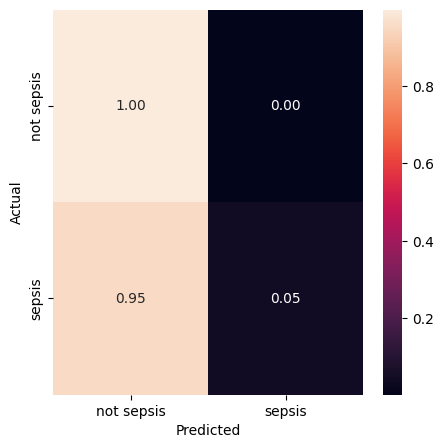

In [63]:
forest, preds = forest_model(split_data)

In [66]:
X_train = split_data['X_train']
X_test = split_data['X_test']
y_train = split_data['y_train']
y_test = split_data['y_test']


param_grid = { 
    'n_estimators': [100, 150, 300], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [10, 15, 30], 
    'max_leaf_nodes': [3, 6, 9], 
} 

grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid=param_grid) 
grid_search.fit(X_train, y_train) 
print(grid_search.best_estimator_) 


MemoryError: Unable to allocate 19.0 MiB for an array with shape (51979, 48) and data type float64